In [18]:
import pandas as pd
import nltk
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch
import numpy as np
import hf_xet

import torch
import torch.nn as nn
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open('debate_transcripts_cleaned.csv', 'r') as f:
    df_transcripts = pd.read_csv(f)

## Vader Analysis

In [4]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def text_preprocess(text):
    # Tokenize text
    wtokens = word_tokenize(text)

    # Filtering tokens
    t_filtered = [t.lower() for t in wtokens if t.lower() not in stop_words and t.isalpha()]

    # Lemmatization
    t_lemmatized = [lem.lemmatize(t) for t in t_filtered]

    return " ".join(t_lemmatized)

""" # Apply preprocessing to the 'dialogue' column
df_cleaned_text = df_transcripts.copy()
df_cleaned_text["cleaned_text"] = df_transcripts['dialogue'].apply(text_preprocess)

# Display the first 15 entries of original and cleaned columns
df_cleaned_text[['dialogue', 'cleaned_text']].head(15) """

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


' # Apply preprocessing to the \'dialogue\' column\ndf_cleaned_text = df_transcripts.copy()\ndf_cleaned_text["cleaned_text"] = df_transcripts[\'dialogue\'].apply(text_preprocess)\n\n# Display the first 15 entries of original and cleaned columns\ndf_cleaned_text[[\'dialogue\', \'cleaned_text\']].head(15) '

In [5]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
%%time
def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores

def add_vader_sentiment(df, text_column='dialogue'):
    
    df['vader_full']= df[text_column].apply(analyze_vader)
    df['vader_sentiment'] = df['vader_full'].apply(lambda x: x['compound'])
    df['vader_label']= df['vader_sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
    return df

add_vader_sentiment(df_transcripts, 'dialogue')

CPU times: total: 4.95 s
Wall time: 5.01 s


,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,"{'neg': 0.074, 'neu': 0.758, 'pos': 0.169, 'co...",0.9993,positive
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,"{'neg': 0.037, 'neu': 0.834, 'pos': 0.129, 'co...",0.9992,positive
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,"{'neg': 0.0, 'neu': 0.961, 'pos': 0.039, 'comp...",0.3612,positive
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,"{'neg': 0.05, 'neu': 0.95, 'pos': 0.0, 'compou...",-0.2732,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9928,2024_Vance_Walz_VP,2024-10-01,2024,Walz,"Well, thank you, Senator Vance. Thank you to C...",True,Democratic,False,True,False,"{'neg': 0.038, 'neu': 0.756, 'pos': 0.206, 'co...",0.9972,positive
9929,2024_Vance_Walz_VP,2024-10-01,2024,Brennan,"Governor Walz. Thank you. Senator Vance, your ...",False,NaN,False,True,False,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.3612,positive
9930,2024_Vance_Walz_VP,2024-10-01,2024,Vance,"Well, I want to thank Governor Walz, you folks...",True,Republican,True,True,False,"{'neg': 0.033, 'neu': 0.801, 'pos': 0.167, 'co...",0.9960,positive
9931,2024_Vance_Walz_VP,2024-10-01,2024,Brennan,"Senator Vance, thank you. And thank you both f...",False,NaN,False,True,False,"{'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'comp...",0.6124,positive


## BERT

In [ ]:
# Load model and tokenizer
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Shared helper: compute sentiment from logits
def compute_sentiment_from_logits(logits):
    probs = softmax(logits.detach().cpu().numpy())
    score_dict = {k: float(v) for k, v in zip(["neg", "neu", "pos"], np.round(probs, 4))}
    polarity_raw = float(np.sum(np.array([-1, 0, 1]) * probs))
    polarity_vader_scaled = float(np.tanh(2 * polarity_raw))
    return pd.Series([score_dict, polarity_raw, polarity_vader_scaled])

# Chunk text into overlapping slices of input_ids
def chunk_text(text, max_length=512, stride=20):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]
    return [tokens[i:i + max_length] for i in range(0, len(tokens), max_length - stride)]

# Sentiment for long texts using chunking
def analyze_long_text(text):
    try:
        token_chunks = chunk_text(text)
        probs_all = []

        for chunk in token_chunks:
            input_ids = chunk.unsqueeze(0)
            attention_mask = torch.ones_like(input_ids)

            with torch.no_grad():
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                probs = softmax(output.logits[0].detach().cpu().numpy())
                probs_all.append(probs)

        avg_probs = np.mean(probs_all, axis=0)
        return compute_sentiment_from_logits(torch.tensor(avg_probs))

    except Exception as e:
        print("Error during long text inference:", e)
        return pd.Series([{"neg": 0.0, "neu": 1.0, "pos": 0.0}, 0.0, 0.0])

# Main function: choose normal or chunked analysis
def analyze_full_sentiment(text, max_length=512):
    try:
        if len(tokenizer.encode(text, truncation=False)) <= max_length:
            encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
            with torch.no_grad():
                output = model(**encoded)
            return compute_sentiment_from_logits(output.logits[0])
        else:
            return analyze_long_text(text)
    except Exception as e:
        print("Error in adaptive sentiment analysis:", e)
        return pd.Series([{"neg": 0.0, "neu": 1.0, "pos": 0.0}, 0.0, 0.0])

# DataFrame application
def add_bert_sentiment(df, text_column="dialogue", alpha=15):
    df[['bert_full', 'bert_raw', 'bert_sentiment']] = df[text_column].apply(analyze_full_sentiment)

    def label_from_polarity(p):
        if p <= -0.05:
            return "negative"
        elif p >= 0.05:
            return "positive"
        else:
            return "neutral"

    df['bert_label'] = df['bert_sentiment'].apply(label_from_polarity)
    return df


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Comparison Values

In [11]:
def add_diff_sentiment(df, text_column='dialogue'):
    df = add_vader_sentiment(df, text_column)
    df = add_bert_sentiment(df, text_column)
    df['diff_sentiment'] = df['vader_sentiment'] - df['bert_sentiment']
    return df

## First Test

In [12]:
%%time
df_sentiment = add_diff_sentiment(df_transcripts, text_column='dialogue')
df_sentiment.to_csv('debate_transcripts_sentiment.csv', index=False)

CPU times: total: 2h 7min 4s
Wall time: 16min 7s


In [13]:
df_sentiment.head()

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_raw,bert_sentiment,bert_label,diff_sentiment
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,"{'neg': 0.074, 'neu': 0.758, 'pos': 0.169, 'co...",0.9993,positive,"{'neg': 0.04089999943971634, 'neu': 0.86820000...",0.049935,0.099539,positive,0.899761
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.009800000116229057, 'neu': 0.9333999...",0.046952,0.093630,positive,-0.093630
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,"{'neg': 0.037, 'neu': 0.834, 'pos': 0.129, 'co...",0.9992,positive,"{'neg': 0.033799998462200165, 'neu': 0.7107999...",0.221595,0.416285,positive,0.582915
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,"{'neg': 0.0, 'neu': 0.961, 'pos': 0.039, 'comp...",0.3612,positive,"{'neg': 0.004900000058114529, 'neu': 0.4332000...",0.557029,0.805492,positive,-0.444292
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,"{'neg': 0.05, 'neu': 0.95, 'pos': 0.0, 'compou...",-0.2732,negative,"{'neg': 0.6265000104904175, 'neu': 0.359499990...",-0.612626,-0.841197,negative,0.567997


In [14]:
df_transcripts.describe(include='all')

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_raw,bert_sentiment,bert_label,diff_sentiment
count,9933,9933,9933.000000,9933,9933,9933,5651,9933,9933,9933,9933,9933.000000,9933,9933,9933.000000,9933.000000,9933,9933.000000
unique,48,48,NaN,171,8563,2,3,2,2,2,5341,NaN,3,8558,NaN,NaN,3,NaN
top,2020_Biden_Trump_1,2020-09-29,NaN,Trump,(CROSSTALK),True,Republican,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",NaN,positive,"{'neg': 0.03009999915957451, 'neu': 0.84270000...",NaN,NaN,negative,NaN
freq,858,858,NaN,930,163,5651,2990,7187,7334,8332,3466,NaN,4309,163,NaN,NaN,4770,NaN
mean,NaN,NaN,2004.906876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149355,NaN,NaN,-0.062801,-0.086610,NaN,0.235965
std,NaN,NaN,14.783792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507132,NaN,NaN,0.438681,0.575056,NaN,0.625452
min,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.998800,NaN,NaN,-0.952835,-0.956720,NaN,-1.919484
25%,NaN,NaN,1992.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.378414,-0.639205,NaN,-0.173282
50%,NaN,NaN,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,-0.009234,-0.018467,NaN,0.099594
75%,NaN,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.493900,NaN,NaN,0.147090,0.285977,NaN,0.620708


In [15]:
df_pres_debate = df_transcripts[(~df_transcripts["VP_debate"])&(df_transcripts["is_candidate"])]

In [16]:
df_pres_debate.sort_values(by='diff_sentiment', ascending=False)

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_full,vader_sentiment,vader_label,bert_full,bert_raw,bert_sentiment,bert_label,diff_sentiment
6723,2016_Clinton Hillary_Trump_1,2016-09-26,2016,Trump,"And she doesnt say that, because shes got no b...",True,Republican,True,False,False,"{'neg': 0.052, 'neu': 0.673, 'pos': 0.275, 'co...",0.9774,positive,"{'neg': 0.847599983215332, 'neu': 0.1362999975...",-0.831485,-0.930616,negative,1.908016
9147,2020_Biden_Trump_2,2020-10-22,2020,Trump,"First of all, Ive already done something that ...",True,Republican,False,False,True,"{'neg': 0.083, 'neu': 0.667, 'pos': 0.249, 'co...",0.9980,positive,"{'neg': 0.7597000002861023, 'neu': 0.209700003...",-0.729094,-0.897300,negative,1.895300
5137,2008_Mccain_Obama_3,2008-10-15,2008,Mccain,"Well, it is a terribly painful situation for A...",True,Republican,False,False,False,"{'neg': 0.034, 'neu': 0.803, 'pos': 0.163, 'co...",0.9868,positive,"{'neg': 0.7753999829292297, 'neu': 0.203199997...",-0.754003,-0.906585,negative,1.893385
1088,1988_Bush Sr_Dukakis_1,1988-09-25,1988,Bush Sr,I think weve seen a deterioration of values. I...,True,Republican,True,False,False,"{'neg': 0.039, 'neu': 0.794, 'pos': 0.168, 'co...",0.9883,positive,"{'neg': 0.7574999928474426, 'neu': 0.227899998...",-0.743009,-0.902589,negative,1.890889
446,1976_Carter_Ford_3,1976-10-22,1976,Ford,I believe that the uh American people have be...,True,Republican,False,False,True,"{'neg': 0.041, 'neu': 0.811, 'pos': 0.148, 'co...",0.9834,positive,"{'neg': 0.7663999795913696, 'neu': 0.218099996...",-0.750879,-0.905465,negative,1.888865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,2008_Mccain_Obama_3,2008-10-15,2008,Mccain,"Well, let let me say, Bob, thank you. And tha...",True,Republican,False,False,False,"{'neg': 0.118, 'neu': 0.804, 'pos': 0.079, 'co...",-0.9247,negative,"{'neg': 0.027499999850988388, 'neu': 0.1046999...",0.840412,0.932968,positive,-1.857668
2389,1992_Bush Sr_Clinton Bill_Perot_3,1992-10-19,1992,Clinton Bill,"4th in manufacturing jobs, 4th in the reductio...",True,Democratic,True,False,False,"{'neg': 0.191, 'neu': 0.714, 'pos': 0.095, 'co...",-0.9255,negative,"{'neg': 0.007799999788403511, 'neu': 0.0903000...",0.894007,0.945551,positive,-1.871051
4587,2008_Mccain_Obama_1,2008-09-26,2008,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,"{'neg': 0.214, 'neu': 0.662, 'pos': 0.125, 'co...",-0.9811,negative,"{'neg': 0.02889999933540821, 'neu': 0.15260000...",0.789705,0.918510,positive,-1.899610
4385,2008_Mccain_Obama_1,2008-09-26,2008,Obama,"Look, Im very proud of my vice presidential se...",True,Democratic,True,False,False,"{'neg': 0.214, 'neu': 0.662, 'pos': 0.125, 'co...",-0.9811,negative,"{'neg': 0.02889999933540821, 'neu': 0.15260000...",0.789705,0.918510,positive,-1.899610


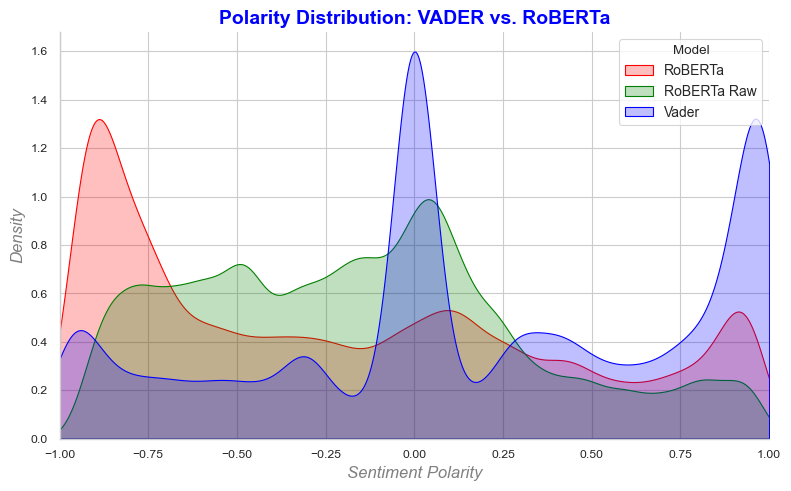

In [21]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette="colorblind", context="paper")

# KDE plot with finer granularity and strict limits
sns.kdeplot(
    df_pres_debate["bert_sentiment"], 
    color="red", 
    fill=True, 
    label="RoBERTa", 
    bw_adjust=0.5, 
    clip=(-1, 1), 
    common_norm=False, 
    gridsize=1000
)

sns.kdeplot(
    df_pres_debate["bert_raw"], 
    color="green", 
    fill=True, 
    label="RoBERTa Raw", 
    bw_adjust=0.5, 
    clip=(-1, 1), 
    common_norm=False, 
    gridsize=1000
)
sns.kdeplot(
    df_pres_debate["vader_sentiment"], 
    color="blue", 
    fill=True, 
    label="Vader", 
    bw_adjust=0.5, 
    clip=(-1, 1), 
    common_norm=False, 
    gridsize=1000
)
plt.xlim(-1, 1)
plt.xlabel("Sentiment Polarity", fontsize=12, fontstyle="italic", color="gray")
plt.ylabel("Density", fontsize=12, fontstyle="italic", color="gray")
plt.title("Polarity Distribution: VADER vs. RoBERTa", fontsize=14, weight="bold", color="blue")
plt.legend(title="Model", fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


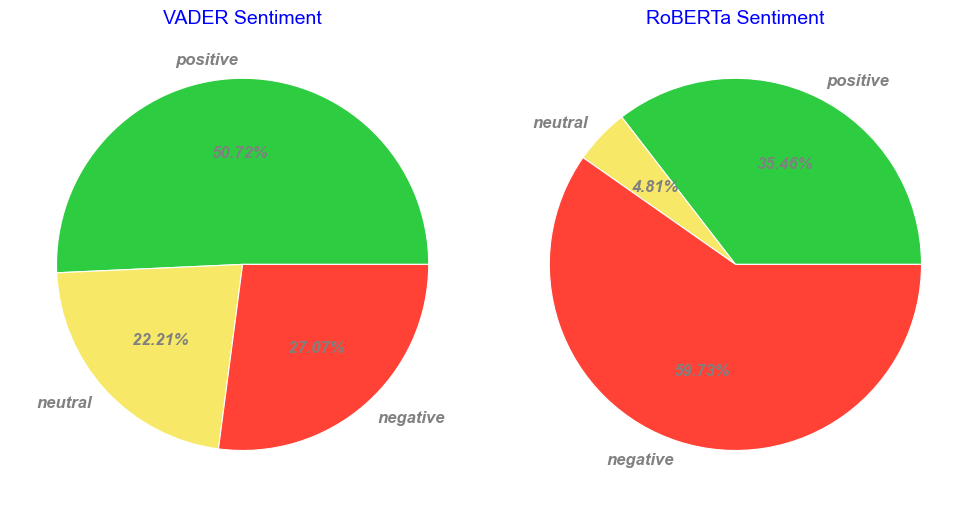

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

colors = ["#2ecc40", "#F7E967", "#ff4136"]  # green, yellow, red
textprops = dict(fontsize=12, fontstyle="italic", weight="bold", color="gray")

# VADER pie chart
df_pres_debate["vader_label"].value_counts(normalize=True).reindex(["positive", "neutral", "negative"]).plot.pie(
    ax=axes[0], autopct="%.2f%%", colors=colors, textprops=textprops, ylabel=""
)
axes[0].set_title("VADER Sentiment", fontsize=14, color="blue")

# RoBERTa pie chart
df_pres_debate["bert_label"].value_counts(normalize=True).reindex(["positive", "neutral", "negative"]).plot.pie(
    ax=axes[1], autopct="%.2f%%", colors=colors, textprops=textprops, ylabel=""
)
axes[1].set_title("RoBERTa Sentiment", fontsize=14, color="blue")

plt.tight_layout()
plt.show()
